In [15]:
import pandas as pd
from darts.models import TFTModel
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt

In [2]:
file_path = 'processed_datasetNew.csv'
data = pd.read_csv(file_path)

data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [3]:
split_date = pd.to_datetime('2008-12-31 23:59')
data = data[data.index >= split_date]

In [4]:
data["Temperature t+24"] = data["Temperature"].shift(periods=-24)
data["Humidity t+24"] = data["Humidity"].shift(periods=-24)
data["Month"] = data.index.month
data["Month_sin"] = np.sin(2 * np.pi * data.index.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data.index.month / 12)
data["Month t+24"] = data["Month"].shift(periods=-24)
data["Month_sin t+24"] = data["Month_sin"].shift(periods=-24)
data["Month_cos t+24"] = data["Month_cos"].shift(periods=-24)
data["Quarter"] = data.index.quarter
data["Quarter_sin"] = np.sin(2 * np.pi * data.index.quarter / 4)
data["Quarter_cos"] = np.cos(2 * np.pi * data.index.quarter / 4)
data["Quarter t+24"] = data["Quarter"].shift(periods=-24)
data["Quarter_sin t+24"] = data["Quarter_sin"].shift(periods=-24)
data["Quarter_cos t+24"] = data["Quarter_cos"].shift(periods=-24)
data["Year"] = data.index.year
data["Year t+24"] = data["Year"].shift(periods=-24)
data['week_cos'] =  np.cos(2 * np.pi * data.index.isocalendar().week / 53)
data['week_sin'] =  np.sin(2 * np.pi * data.index.isocalendar().week / 53)
data["week_sin t+24"] = data["week_sin"].shift(periods=-24)
data["week_cos t+24"] = data["week_cos"].shift(periods=-24)
data['weekday_cos'] = np.sin(2 * np.pi * (data.index.weekday+1) / 7)
data['weekday_sin'] = np.cos(2 * np.pi * (data.index.weekday+1) / 7)
data["weekday_sin t+24"] = data["weekday_sin"].shift(periods=-24)
data["weekday_cos t+24"] = data["weekday_cos"].shift(periods=-24)

In [5]:
features_options = [
    ["Temperature", "Humidity"],
    ["Temperature", "Humidity", "Year", "Month"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "weekday_cos", "weekday_sin"],
    ["Temperature", "Humidity", "Temperature t+24", "Humidity t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Temperature t+24", "Humidity t+24", "Year t+24", "Month t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "Temperature t+24", "Humidity t+24", "Year t+24", 
    "Month t+24", "Month_cos t+24", "Month_sin t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "weekday_cos", "weekday_cos", "Temperature t+24", "Humidity t+24",
    "Year t+24", "Month t+24", "Month_cos t+24", "Month_sin t+24", "weekday_cos t+24", "weekday_sin t+24"],
    ["Temperature", "Humidity", "Year", "weekday_cos", "weekday_sin", "Month_cos", "Month_sin"],
    ["Temperature", "Humidity", "Year", "weekday_cos", "weekday_sin", "Temperature t+24", "Humidity t+24", "Year t+24", "weekday_cos t+24", "weekday_sin t+24"]
]

In [6]:
data_sin = data[['SIN']]
data_cov = data[features_options[3]]

In [7]:
series = TimeSeries.from_dataframe(data_sin, value_cols=["SIN"])
covariates = TimeSeries.from_dataframe(data_cov, value_cols=features_options[3])
series = series.astype(np.float32)
covariates = covariates.astype(np.float32)

In [8]:
# # Create training and validation sets:
training_cutoff = pd.Timestamp("20191231T230000")
train, val = series.split_after(training_cutoff)

In [9]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [10]:
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
cov_train, cov_val = covariates.split_after(training_cutoff)
# cov_val, cov_test = covariates.split_after(validation_cutoff)

In [11]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
covariates_transformed_train = scaler_covs.fit_transform(cov_train)
covariates_transformed_val = scaler_covs.transform(cov_val)
covariates_transformed = scaler_covs.transform(covariates)

In [12]:
tft_model_path = "Models/TFT_2009-2022_01/tft_model_01.pt"
tft_01 = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_02/tft_model_02.pt"
tft_02 = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_04/tft_model_04.pt"
tft_04 = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_05/tft_model_05.pt"
tft_05 = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_06/tft_model_06.pt"
tft_06 = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_07/tft_model_07.pt"
tft_07 = TFTModel.load(tft_model_path)

In [13]:
# Predictions for 2022 (24 hours ahead)
tft_pred_01 = tft_01.predict(n=24, future_covariates=covariates_transformed)
tft_pred_01 = transformer.inverse_transform(tft_pred_01)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\siljo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [17]:
# Predictions for 2022 (24 hours ahead)
tft_pred_02 = tft_02.predict(n=24, future_covariates=covariates_transformed)
tft_pred_02 = transformer.inverse_transform(tft_pred_02)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\siljo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

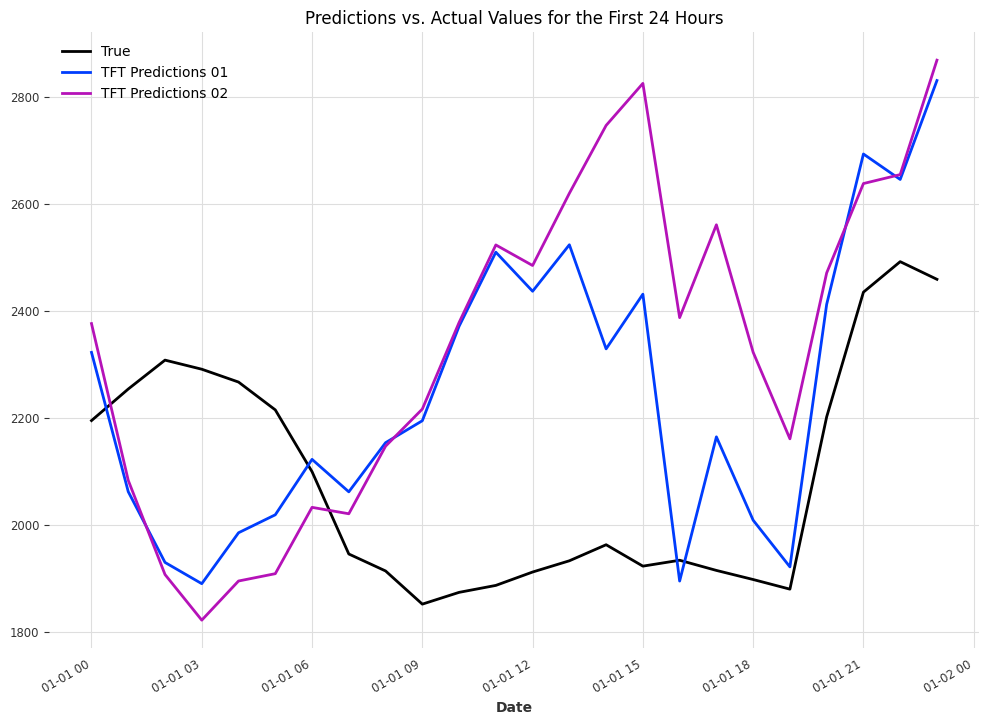

In [19]:
# Extracting the first 24 hours from actual and prediction data
valid_24h = val[:24]
tft_pred_24h_01 = tft_pred_01[:24]
tft_pred_24h_02 = tft_pred_02[:24]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(12, 8))
valid_24h.plot(label='True', lw=2)
tft_pred_24h_01.plot(label='TFT Predictions 01', lw=2)
tft_pred_24h_02.plot(label='TFT Predictions 02', lw=2)
plt.title("Predictions vs. Actual Values for the First 24 Hours")
plt.legend()
plt.show()

In [56]:
n = len(val)  # Get the length of the validation dataset
tft_pred_val_01 = tft_01.predict(n=n, future_covariates=covariates_transformed)
tft_pred_val_01 = transformer.inverse_transform(tft_pred_val_01)

tft_pred_val_02 = tft_02.predict(n=n, future_covariates=covariates_transformed)
tft_pred_val_02 = transformer.inverse_transform(tft_pred_val_02)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\siljo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\siljo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ValueError: The provided `historic_future_covariates` must have equal dimensionality as the `historic_future_covariates` used for training the model.


ValueError: The provided `historic_future_covariates` must have equal dimensionality as the `historic_future_covariates` used for training the model.

In [60]:
data_cov = data[features_options[8]]
series = TimeSeries.from_dataframe(data_sin, value_cols=["SIN"])
covariates = TimeSeries.from_dataframe(data_cov, value_cols=features_options[8])
series = series.astype(np.float32)
covariates = covariates.astype(np.float32)
training_cutoff = pd.Timestamp("20191231T230000")
train, val = series.split_after(training_cutoff)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs = Scaler()
covariates_transformed_train = scaler_covs.fit_transform(cov_train)
covariates_transformed_val = scaler_covs.transform(cov_val)
covariates_transformed = scaler_covs.transform(covariates)

tft_pred_val_05 = tft_05.predict(n=n, future_covariates=covariates_transformed)
tft_pred_val_05 = transformer.inverse_transform(tft_pred_val_05)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\siljo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [ ]:
# Convert TimeSeries to numpy arrays
tft_pred_val_arr_01 = tft_pred_val_01.values()
tft_pred_val_arr_02 = tft_pred_val_02.values()
tft_pred_val_arr_05 = tft_pred_val_05.values()
val_arr = val.values()

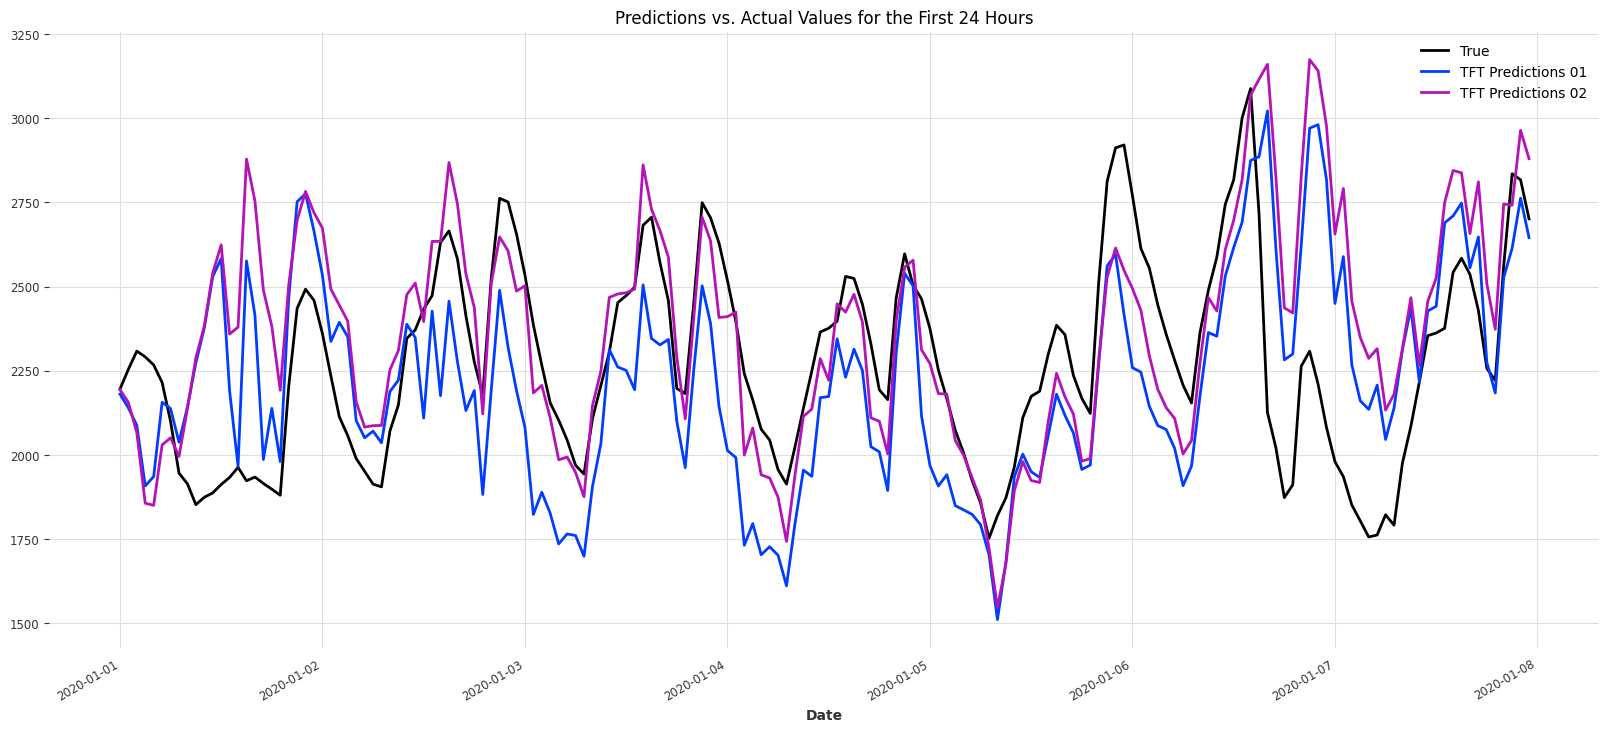

In [26]:
# Extracting the first week from actual and prediction data
valid_1w = val[:24*7]
tft_pred_1w_01 = tft_pred_val_01[:24*7]
tft_pred_1w_02 = tft_pred_val_02[:24*7]
tft_pred_1w_05 = tft_pred_val_05[:24*7]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_24h.plot(label='True', lw=2)
tft_pred_1w_01.plot(label='TFT Predictions 01', lw=2)
tft_pred_1w_02.plot(label='TFT Predictions 02', lw=2)
plt.title("Predictions vs. Actual Values for the First 24 Hours")
plt.legend()
plt.show()

In [38]:
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
# mse=mean_squared_error( val_arr, tft_pred_val_arr_01)
# rmse=np.sqrt(mse)

# Define a function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Initialize an empty list to store RMSE values for each 24-hour period
rmse_values = []

# Calculate RMSE for each 24-hour period
for i in range(len(val_arr) - 23):
    period_actual = val_arr[i:i+24]
    period_predicted = tft_pred_val_arr_01[i:i+24]
    period_rmse = rmse(period_predicted, period_actual)
    rmse_values.append(period_rmse)

# Convert the list to a NumPy array
rmse_values = np.array(rmse_values)

# Find the index of the minimum RMSE value
min_rmse_index = np.argmin(rmse_values)
min_rmse = rmse_values[min_rmse_index]

# Assuming you want to know the start and end indices of the best period
best_period_start_index = min_rmse_index
best_period_end_index = min_rmse_index + 23

print(f"Best 24-hour period starts at index: {best_period_start_index} and ends at index: {best_period_end_index}")
print(f"RMSE for this period is: {min_rmse}")

Best 24-hour period starts at index: 4499 and ends at index: 4522
RMSE for this period is: 42.14676284790039


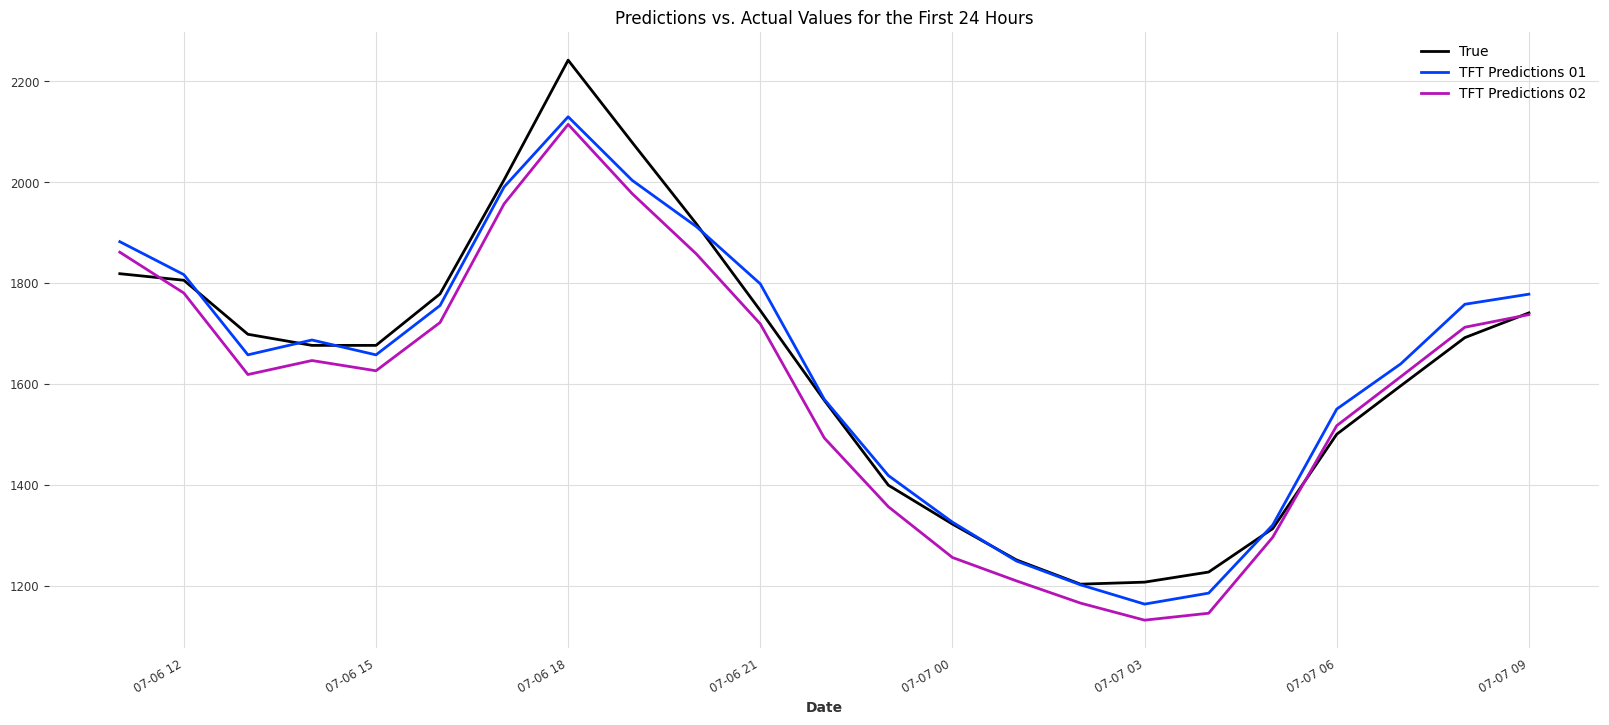

In [39]:
# Extracting the first week from actual and prediction data
valid_1w = val[4499:4522]
tft_pred_1w_01 = tft_pred_val_01[4499:4522]
tft_pred_1w_02 = tft_pred_val_02[4499:4522]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_1w.plot(label='True', lw=2)
tft_pred_1w_01.plot(label='TFT Predictions 01', lw=2)
tft_pred_1w_02.plot(label='TFT Predictions 02', lw=2)
plt.title("Predictions vs. Actual Values for the First 24 Hours")
plt.legend()
plt.show()

In [48]:
# Define the start datetime
start_datetime = pd.Timestamp('2020-01-01 00:00')

# Create a date range for the timestamps
timestamps = pd.date_range(start=start_datetime, periods=len(val_arr), freq='H')

# Define a function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

# Now you can calculate the RMSE for each day
unique_days = np.unique(timestamps.date)

# Initialize a dictionary to store RMSE and index values for each day
daily_rmse_and_indices_01 = {}
daily_rmse_and_indices_02 = {}

# Calculate RMSE for each day
for day in unique_days:
    # Indices of the entries for the current day
    day_indices = np.where(timestamps.date == day)
    
    # Extract the actual and predicted values for the current day
    day_actual = val_arr[day_indices]
    day_predicted_01 = tft_pred_val_arr_01[day_indices]
    day_predicted_02 = tft_pred_val_arr_02[day_indices]
    
    # Calculate the RMSE and store it along with the indices
    daily_rmse_and_indices_01[day] = (rmse(day_predicted_01, day_actual), day_indices[0][0], day_indices[0][-1])
    daily_rmse_and_indices_02[day] = (rmse(day_predicted_02, day_actual), day_indices[0][0], day_indices[0][-1])

# Find the day with the minimum RMSE
best_day_01, best_day_info_01 = min(daily_rmse_and_indices_01.items(), key=lambda x: x[1][0])
min_rmse_01, start_index_01, end_index_01 = best_day_info_01

best_day_02, best_day_info_02 = min(daily_rmse_and_indices_02.items(), key=lambda x: x[1][0])
min_rmse_02, start_index_02, end_index_02 = best_day_info_02

print(f"Best day for 01 is: {best_day_01} with an RMSE of: {min_rmse_01}")
print(f"The index interval for this day is: {start_index_01} to {end_index_01}")
print(f"Best day 02 is: {best_day_02} with an RMSE of: {min_rmse_02}")
print(f"The index interval for this day is: {start_index_02} to {end_index_02}")

Best day for 01 is: 2020-08-16 with an RMSE of: 50.27236557006836
The index interval for this day is: 5472 to 5495
Best day 02 is: 2020-07-13 with an RMSE of: 52.10844421386719
The index interval for this day is: 4656 to 4679


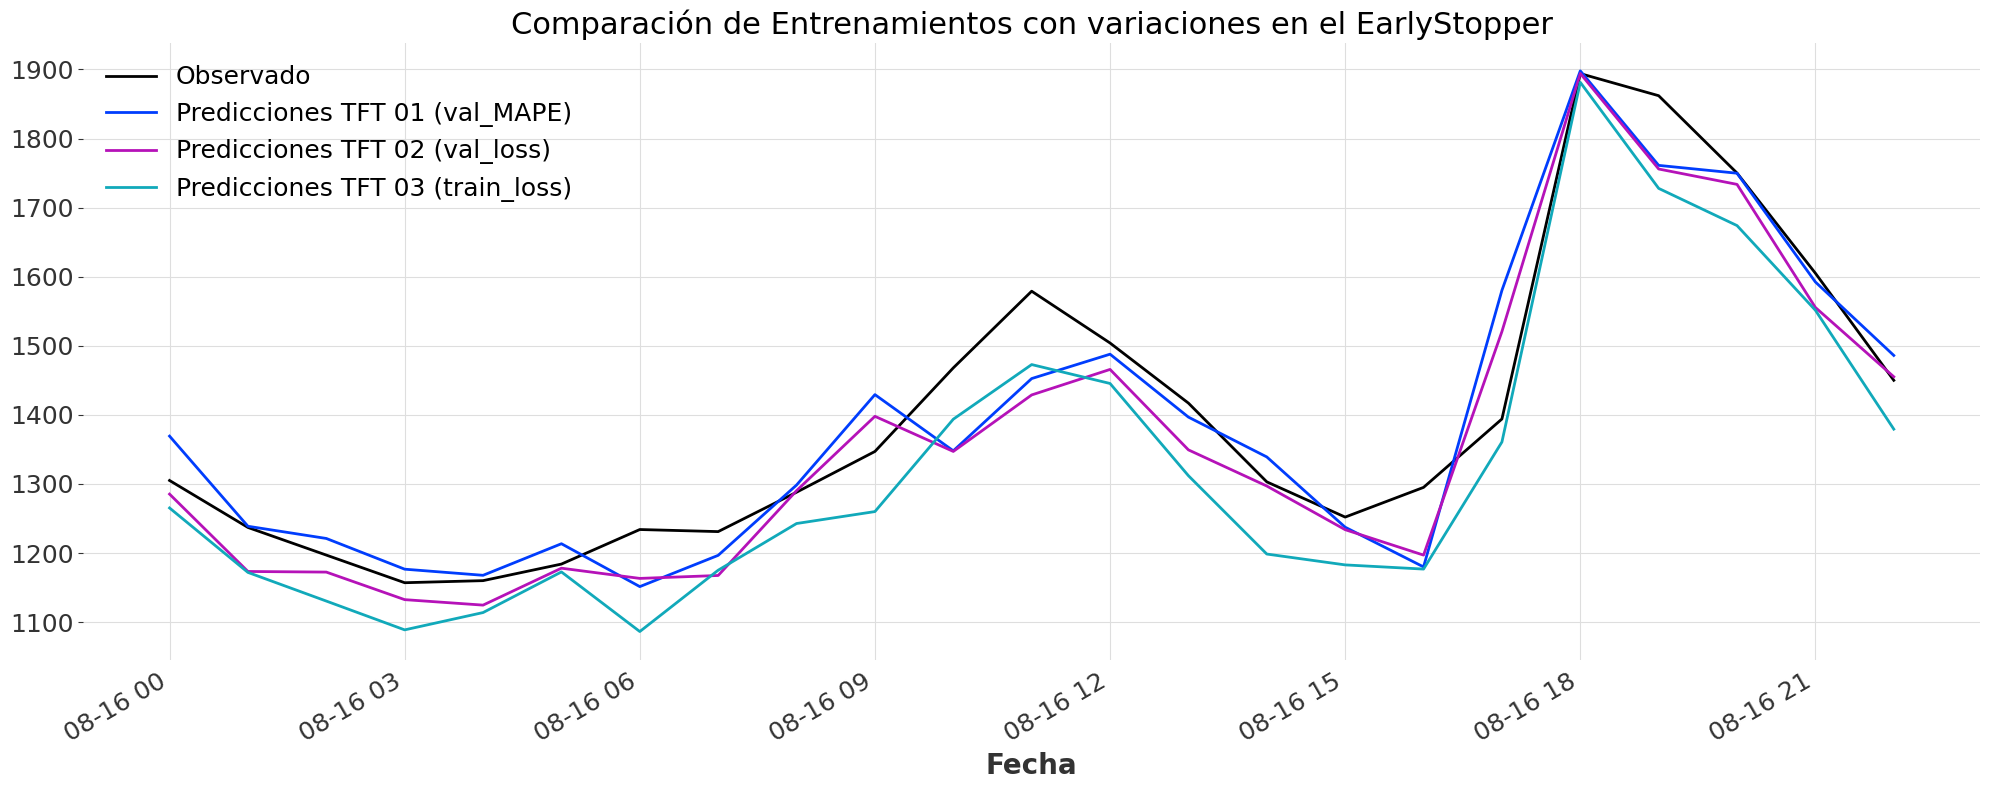

In [78]:
# Extracting the first week from actual and prediction data
valid_1w = val[5472:5495]
tft_pred_1w_01 = tft_pred_val_01[5472:5495]
tft_pred_1w_02 = tft_pred_val_02[5472:5495]
tft_pred_1w_05 = tft_pred_val_05[5472:5495]

plt.rcParams['axes.titlesize'] = 22  # Title size
plt.rcParams['axes.labelsize'] = 20  # Axis label size
plt.rcParams['xtick.labelsize'] = 18 # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 18 # Y-axis tick label size
plt.rcParams['legend.fontsize'] = 18 # Legend font size

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_1w.plot(label='Observado', lw=2)
tft_pred_1w_01.plot(label='Predicciones TFT 01 (val_MAPE)', lw=2)
tft_pred_1w_02.plot(label='Predicciones TFT 02 (val_loss)', lw=2)
tft_pred_1w_05.plot(label='Predicciones TFT 03 (train_loss)', lw=2)
plt.xlabel("Fecha")
plt.title("Comparación de Entrenamientos con variaciones en el EarlyStopper")
plt.legend()

plt.tight_layout()
plt.savefig('early_model_func_comp.png', format='png', dpi=300)

plt.show()



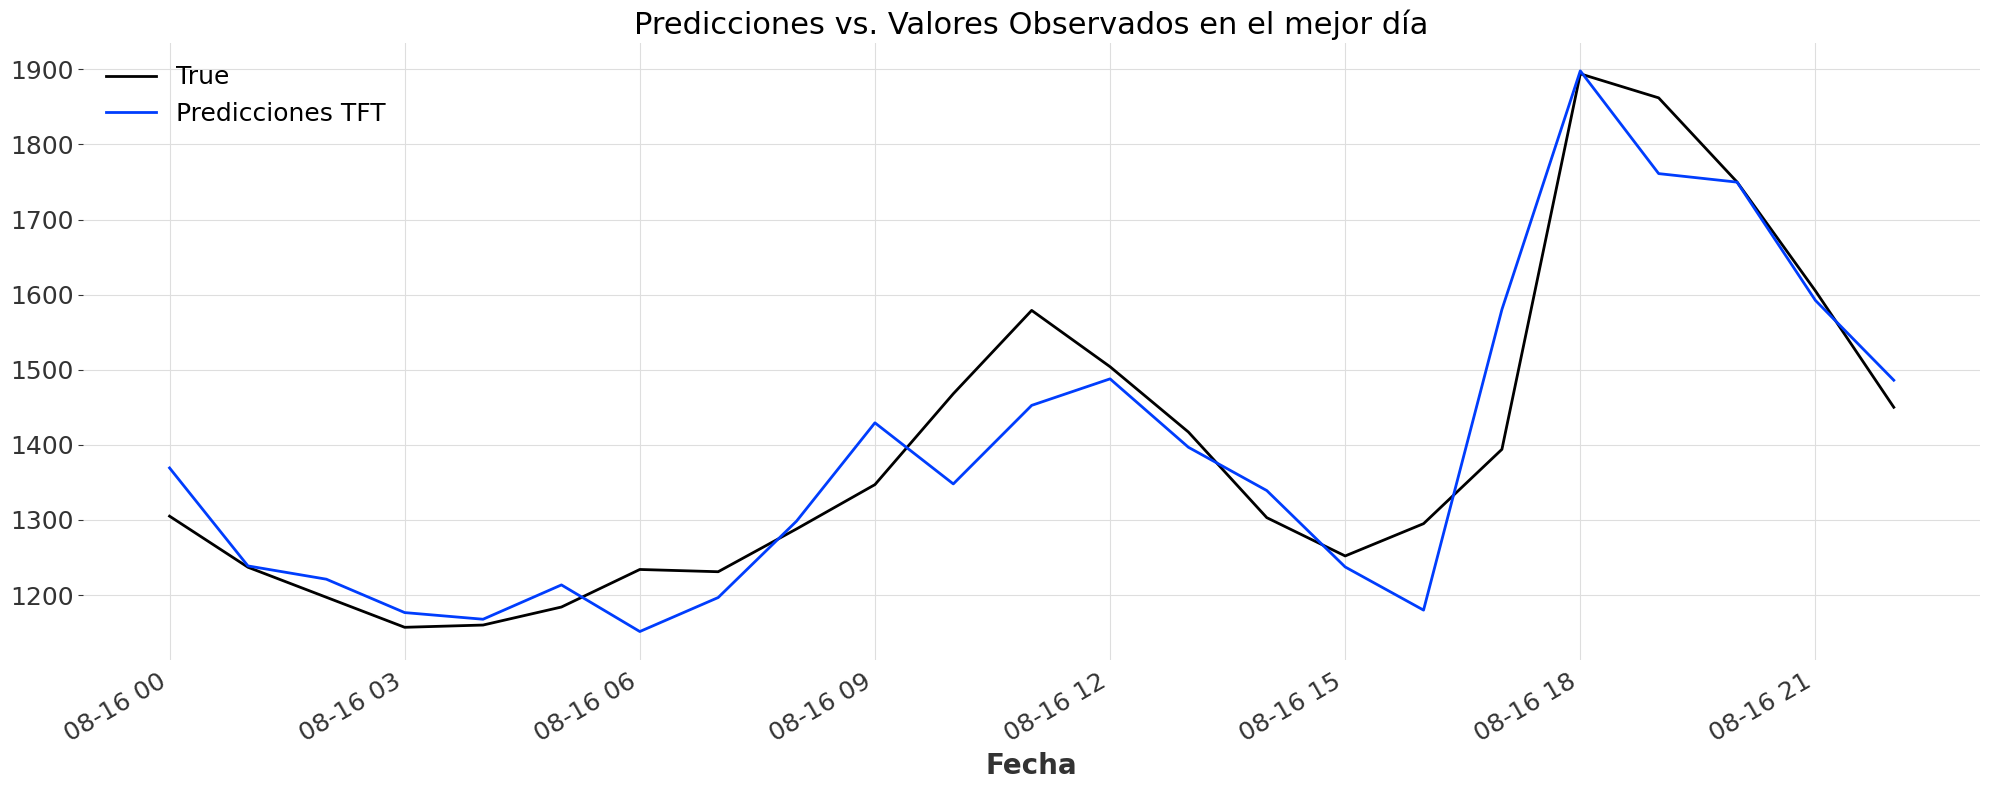

In [79]:
# Extracting the first week from actual and prediction data
# Selection deleted

valid_1w = val[5472:5495]
tft_pred_1w_01 = tft_pred_val_01[5472:5495]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_1w.plot(label='True', lw=2)
tft_pred_1w_01.plot(label='Predicciones TFT', lw=2)
# tft_pred_1w_02.plot(label='TFT Predictions 02', lw=2)
plt.title("Predicciones vs. Valores Observados en el mejor día")
plt.xlabel("Fecha")
plt.legend()

plt.tight_layout()
plt.savefig('best_day_tft01.png', format='png', dpi=300)

plt.show()